# E-commerce Data Exploration

Explore the processed e-commerce data from Hive tables.

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Initialize Spark with Hive support
spark = SparkSession.builder \
    .appName("DataExploration") \
    .config("spark.sql.warehouse.dir", "hdfs://namenode:9000/user/hive/warehouse") \
    .config("hive.metastore.uris", "thrift://hive-metastore:9083") \
    .enableHiveSupport() \
    .getOrCreate()

print("✅ Spark session initialized!")

✅ Spark session initialized!


## 1. Dataset Overview

In [2]:
# Load cleaned data
df = spark.table("silver.ecommerce_cleaned")

print(f"Total records: {df.count():,}")
print(f"\nSchema:")
df.printSchema()

print("\nSample data:")
df.show(5, truncate=False)

Total records: 1,000,000

Schema:
root
 |-- event_time: timestamp (nullable = true)
 |-- event_type: string (nullable = true)
 |-- product_id: integer (nullable = true)
 |-- category_id: long (nullable = true)
 |-- category_code: string (nullable = true)
 |-- brand: string (nullable = true)
 |-- price: double (nullable = true)
 |-- user_id: integer (nullable = true)
 |-- user_session: string (nullable = true)
 |-- event_year: integer (nullable = true)
 |-- event_month: integer (nullable = true)
 |-- event_day: integer (nullable = true)
 |-- event_hour: integer (nullable = true)
 |-- event_weekday: integer (nullable = true)
 |-- price_range: string (nullable = true)
 |-- processing_timestamp: timestamp (nullable = true)
 |-- event_date: date (nullable = true)


Sample data:
+-------------------+----------+----------+-------------------+-----------------------------------+-------------+-------+---------+------------------------------------+----------+-----------+---------+----------+----

## 2. Event Type Distribution

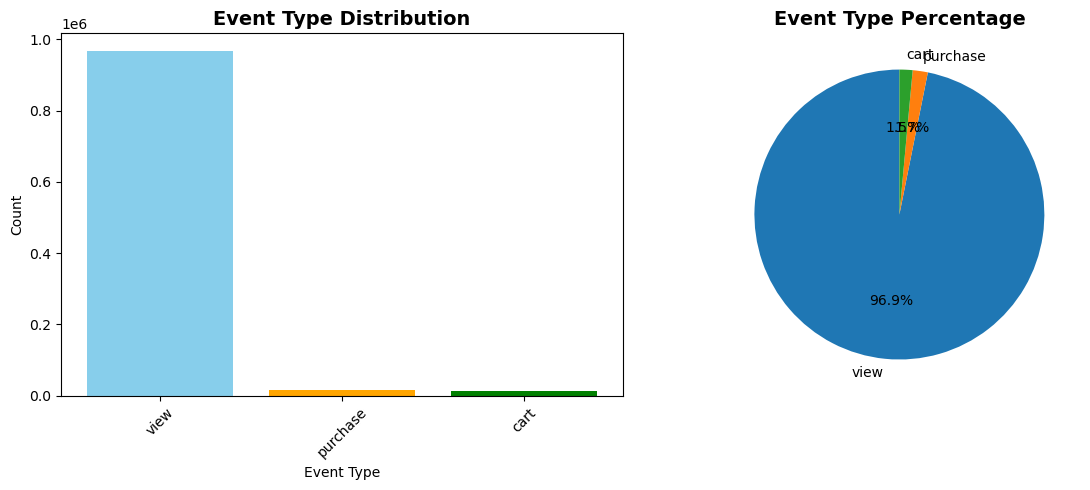


Event Statistics:
  event_type   count
0       view  968513
1   purchase   16848
2       cart   14639


In [3]:
# Event distribution
event_dist = df.groupBy("event_type").count().orderBy("count", ascending=False).toPandas()

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.bar(event_dist['event_type'], event_dist['count'], color=['skyblue', 'orange', 'green'])
plt.title('Event Type Distribution', fontsize=14, fontweight='bold')
plt.xlabel('Event Type')
plt.ylabel('Count')
plt.xticks(rotation=45)

plt.subplot(1, 2, 2)
plt.pie(event_dist['count'], labels=event_dist['event_type'], autopct='%1.1f%%', startangle=90)
plt.title('Event Type Percentage', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

print("\nEvent Statistics:")
print(event_dist)

## 3. Temporal Analysis

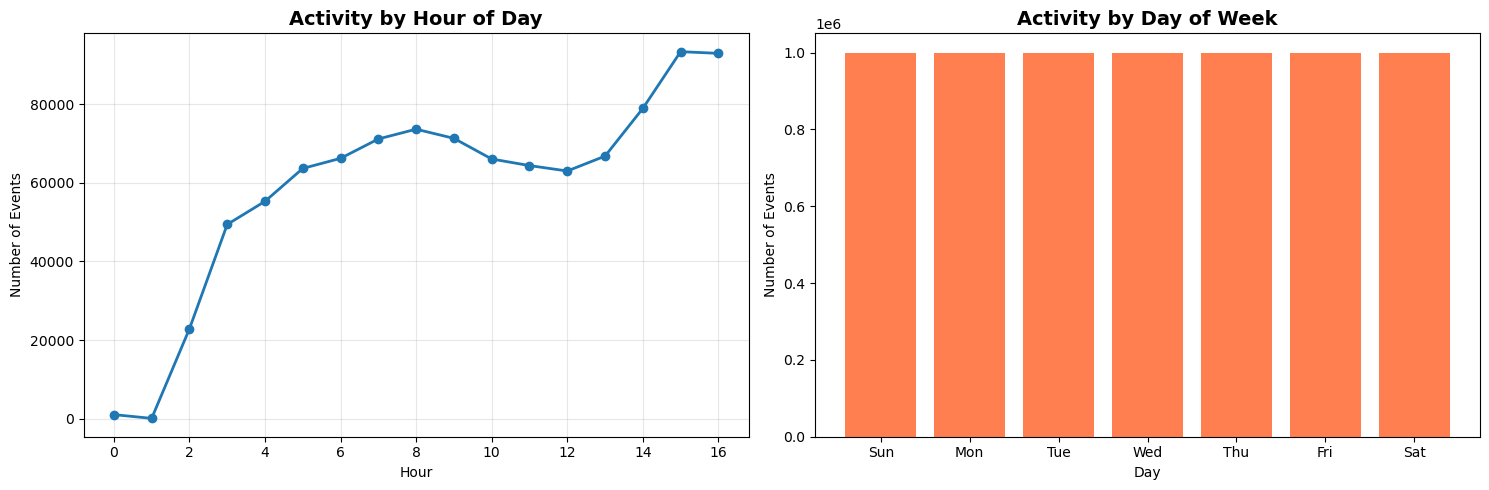

In [4]:
# Hourly activity
hourly = df.groupBy("event_hour").count().orderBy("event_hour").toPandas()

# Weekday activity
weekday = df.groupBy("event_weekday").count().orderBy("event_weekday").toPandas()
weekday_names = ['Sun', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat']

plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(hourly['event_hour'], hourly['count'], marker='o', linewidth=2)
plt.title('Activity by Hour of Day', fontsize=14, fontweight='bold')
plt.xlabel('Hour')
plt.ylabel('Number of Events')
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.bar(weekday_names, weekday['count'], color='coral')
plt.title('Activity by Day of Week', fontsize=14, fontweight='bold')
plt.xlabel('Day')
plt.ylabel('Number of Events')

plt.tight_layout()
plt.show()

## 4. Price Analysis

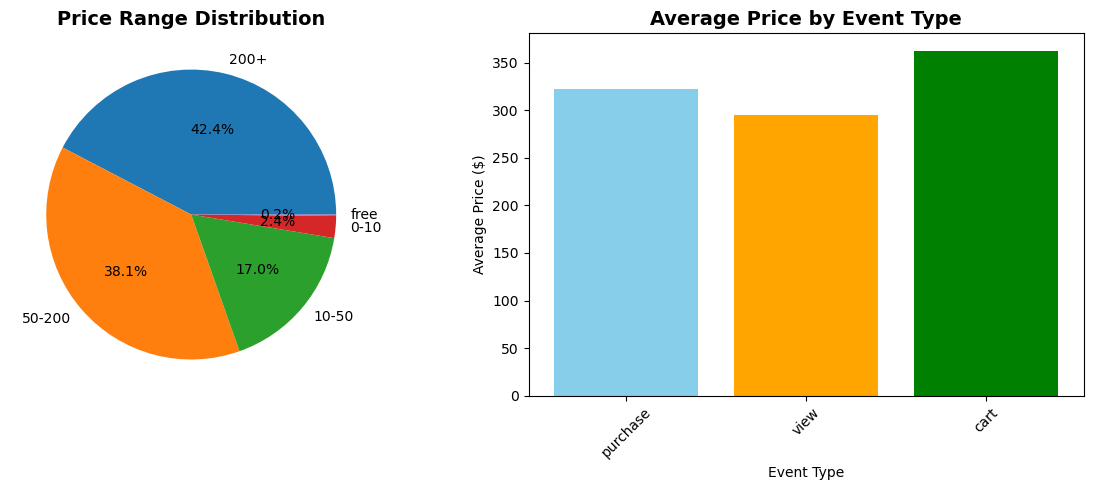


Price Statistics:
+----------+------------------+---------+---------+
|event_type|         avg_price|min_price|max_price|
+----------+------------------+---------+---------+
|  purchase| 322.6261888651504|     0.79|  2573.79|
|      view|295.00260418277725|     0.79|  2574.07|
|      cart|362.52998702097733|     4.07|   2072.1|
+----------+------------------+---------+---------+



In [5]:
# Price range distribution
price_range = df.groupBy("price_range").count().orderBy("count", ascending=False).toPandas()

# Average price by event type
avg_price = df.filter(col("price") > 0).groupBy("event_type").agg(avg("price").alias("avg_price")).toPandas()

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.pie(price_range['count'], labels=price_range['price_range'], autopct='%1.1f%%')
plt.title('Price Range Distribution', fontsize=14, fontweight='bold')

plt.subplot(1, 2, 2)
plt.bar(avg_price['event_type'], avg_price['avg_price'], color=['skyblue', 'orange', 'green'])
plt.title('Average Price by Event Type', fontsize=14, fontweight='bold')
plt.xlabel('Event Type')
plt.ylabel('Average Price ($)')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

print("\nPrice Statistics:")
df.filter(col("price") > 0).groupBy("event_type").agg(
    avg("price").alias("avg_price"),
    min("price").alias("min_price"),
    max("price").alias("max_price")
).show()

## 5. Top Brands and Categories

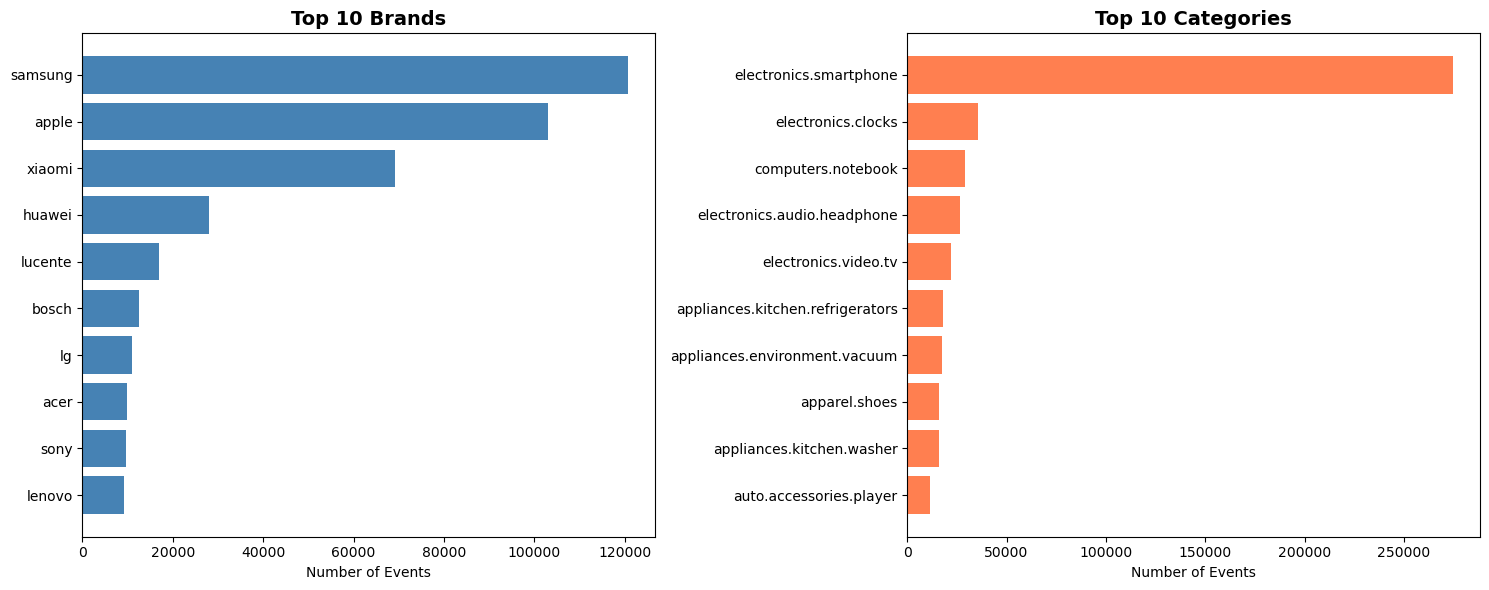

In [6]:
# Top brands
top_brands = df.filter(col("brand") != "unknown_brand") \
    .groupBy("brand").count() \
    .orderBy("count", ascending=False) \
    .limit(10).toPandas()

# Top categories
top_categories = df.filter(col("category_code") != "unknown_category") \
    .groupBy("category_code").count() \
    .orderBy("count", ascending=False) \
    .limit(10).toPandas()

plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
plt.barh(top_brands['brand'], top_brands['count'], color='steelblue')
plt.title('Top 10 Brands', fontsize=14, fontweight='bold')
plt.xlabel('Number of Events')
plt.gca().invert_yaxis()

plt.subplot(1, 2, 2)
plt.barh(top_categories['category_code'], top_categories['count'], color='coral')
plt.title('Top 10 Categories', fontsize=14, fontweight='bold')
plt.xlabel('Number of Events')
plt.gca().invert_yaxis()

plt.tight_layout()
plt.show()

## 6. Key Business Metrics

In [7]:
# Calculate key metrics
total_users = df.select("user_id").distinct().count()
total_sessions = df.select("user_session").distinct().count()
total_products = df.select("product_id").distinct().count()
total_events = df.count()

# Event type counts
views = df.filter(col("event_type") == "view").count()
carts = df.filter(col("event_type") == "cart").count()
purchases = df.filter(col("event_type") == "purchase").count()

# Conversion rates
view_to_cart = (carts / views * 100) if views > 0 else 0
cart_to_purchase = (purchases / carts * 100) if carts > 0 else 0
overall_conversion = (purchases / views * 100) if views > 0 else 0

print("=" * 60)
print("KEY BUSINESS METRICS")
print("=" * 60)
print(f"\n📊 OVERVIEW:")
print(f"   • Total Users: {total_users:,}")
print(f"   • Total Sessions: {total_sessions:,}")
print(f"   • Total Products: {total_products:,}")
print(f"   • Total Events: {total_events:,}")
print(f"\n🎯 CONVERSION FUNNEL:")
print(f"   • Views: {views:,}")
print(f"   • Cart Adds: {carts:,}")
print(f"   • Purchases: {purchases:,}")
print(f"\n📈 CONVERSION RATES:")
print(f"   • View to Cart: {view_to_cart:.2f}%")
print(f"   • Cart to Purchase: {cart_to_purchase:.2f}%")
print(f"   • Overall Conversion: {overall_conversion:.2f}%")
print("=" * 60)

KEY BUSINESS METRICS

📊 OVERVIEW:
   • Total Users: 163,024
   • Total Sessions: 226,374
   • Total Products: 63,322
   • Total Events: 1,000,000

🎯 CONVERSION FUNNEL:
   • Views: 968,513
   • Cart Adds: 14,639
   • Purchases: 16,848

📈 CONVERSION RATES:
   • View to Cart: 1.51%
   • Cart to Purchase: 115.09%
   • Overall Conversion: 1.74%
